In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional, Union, Any

import sys
sys.path.append('../titan')
import titan_network
from titan_network import \
    EmissionBucket, TitanSimulationConfig, TitanTokenSimulation, \
    Deal

import numpy as np

In [3]:
# Function to generate random deals for testing
def generate_random_deals(
    num_deals: int,
    max_months: int,
    value_range: Tuple[float, float],
    geographies: List[str],
    price_range: Tuple[float, float] = (0.5, 0.5),  # Default to static $0.50 price
    seed: Optional[int] = None
) -> List[Deal]:
    """
    Generate random deals for simulation testing.
    
    Args:
        num_deals: Number of deals to generate
        max_months: Maximum month index for deals
        value_range: (min_value, max_value) range for deal values
        geographies: List of possible geographies
        price_range: (min_price, max_price) range for token price. If min=max, price will be static
        seed: Random seed for reproducibility
        
    Returns:
        List of randomly generated Deal objects
    """
    if seed is not None:
        np.random.seed(seed)
    
    deals = []
    for _ in range(num_deals):
        value = np.random.uniform(*value_range)
        start_month = np.random.randint(0, max_months)
        geography = np.random.choice(geographies)
        token_price = np.random.uniform(*price_range)
        deals.append(Deal(
            value=value, 
            start_month=start_month, 
            geography=geography,
            token_price=token_price
        ))
    
    return deals

In [4]:
# Define emission buckets
buckets = [
    EmissionBucket(
        name="Labs",
        emissions_per_month=400_000_000/48.0,
        start_month=0,  # configure cliff here
        months_to_emit=48,  # 4-year vesting
        initial_supply=1_680_000
    ),
    EmissionBucket(
        name="Foundation",
        emissions_per_month=200_000_000/48.0,
        start_month=0,
        months_to_emit=48,
        initial_supply=420_000
    ),
    EmissionBucket(
        name="Fundraising - Seed",
        emissions_per_month=34_000_000/36.0,
        start_month=0,
        months_to_emit=36,
        initial_supply=17_000
    ),
    EmissionBucket(
        name="Fundraising - A",
        emissions_per_month=166_000_000/36.0,
        start_month=0,
        months_to_emit=36,
        initial_supply=381_800
    ),
    EmissionBucket(
        name="Ecosystem",
        emissions_per_month=100_000_000/48.0,
        start_month=0,
        months_to_emit=48,
        initial_supply=0.0010*100_000_000
    ),
    EmissionBucket(
        name="Testnet Token Allocation",
        emissions_per_month=90_000_000/12.0,
        start_month=0,
        months_to_emit=12,
        initial_supply=0.0038*90_000_000
    ),
    EmissionBucket(
        name="Market Making Reserve",  # assume all liquid immediately for the market
                                       # double check whether this makes sense
        emissions_per_month=0,
        start_month=0,
        months_to_emit=0,
        initial_supply=90_000_000
    ),
    EmissionBucket(
        name="Builder, Startup & Devs",
        emissions_per_month=60_000_000/120.0,
        start_month=4,
        months_to_emit=120,
        initial_supply=0
    ),
    EmissionBucket(
        name="RPGF",
        emissions_per_month=60_000_000/120.0,
        start_month=4,
        months_to_emit=120,
        initial_supply=0
    ),
]

# Define geography multipliers
geo_multipliers = {
    "North America": 1.2,
    "Europe": 1.1,
    "Asia": 0.9,
    "Other": 0.8
}

# Create simulation config
config = TitanSimulationConfig(
    buckets=buckets,
    delta=0.01,  # 1% of deal value converted to deal inflationary rewards
    beta=0.05,   # Decay rate
    geography_multipliers=geo_multipliers,
    buyback_portion=0.8,  # 80% of deal value used for buybacks
    simulation_months=120,  # 10 years
    buyback_vesting_months=1,  # assume deals are on a monthly cadence
    validator_total_rewards=200_000_000,
    validator_half_life_months=72,
    locking_vector=np.ones(120)*1_000_000
)

# Generate random deals
deals = generate_random_deals(
    num_deals=120,  # 1 deal / month
    max_months=120,
    value_range=(75_000, 125_000),  # average 100k
    geographies=list(geo_multipliers.keys()),
    price_range=(0.05, 0.10),  # token price between 0.05 and 0.10
    seed=42
)


In [5]:
# Create and run simulation
simulation = TitanTokenSimulation(config)
results = simulation.run(deals)

In [6]:
results.columns

Index(['fixed_Labs', 'fixed_Foundation', 'fixed_Fundraising - Seed',
       'fixed_Fundraising - A', 'fixed_Ecosystem',
       'fixed_Testnet Token Allocation', 'fixed_Market Making Reserve',
       'fixed_Builder, Startup & Devs', 'fixed_RPGF', 'deal_emissions',
       'total_dynamic_emissions', 'buyback_reduction', 'vested_buybacks',
       'validator_rewards', 'total_fixed_emissions', 'total_emissions',
       'cumulative_emissions', 'net_buyback_impact', 'circulating_supply',
       'locked_supply'],
      dtype='object')

In [7]:
results

,fixed_Labs,fixed_Foundation,fixed_Fundraising - Seed,fixed_Fundraising - A,fixed_Ecosystem,fixed_Testnet Token Allocation,fixed_Market Making Reserve,"fixed_Builder, Startup & Devs",fixed_RPGF,deal_emissions,total_dynamic_emissions,buyback_reduction,vested_buybacks,validator_rewards,total_fixed_emissions,total_emissions,cumulative_emissions,net_buyback_impact,circulating_supply,locked_supply
Month,,,,,,,,,,,,,,,,,,,,
0,1.001333e+07,4.586667e+06,961444.444444,4.992911e+06,2.183333e+06,7842000.0,90000000.0,0.0,0.0,2921.235530,2.092323e+06,4.360487e+06,4.360487e+06,1.925409e+06,1.205797e+08,1.226720e+08,1.226720e+08,0.0,1.216720e+08,1000000.0
1,8.333333e+06,4.166667e+06,944444.444444,4.611111e+06,2.083333e+06,7500000.0,0.0,0.0,0.0,4565.264704,2.224093e+06,2.072455e+06,2.072455e+06,1.906962e+06,2.763889e+07,2.986298e+07,1.525350e+08,0.0,1.515350e+08,1000000.0
2,8.333333e+06,4.166667e+06,944444.444444,4.611111e+06,2.083333e+06,7500000.0,0.0,0.0,0.0,4342.614117,2.190356e+06,0.000000e+00,0.000000e+00,1.888691e+06,2.763889e+07,2.982925e+07,1.823642e+08,0.0,1.813642e+08,1000000.0
3,8.333333e+06,4.166667e+06,944444.444444,4.611111e+06,2.083333e+06,7500000.0,0.0,0.0,0.0,4850.531944,2.187777e+06,9.043290e+05,9.043290e+05,1.870596e+06,2.763889e+07,2.982667e+07,2.121909e+08,0.0,2.111909e+08,1000000.0
4,8.333333e+06,4.166667e+06,944444.444444,4.611111e+06,2.083333e+06,7500000.0,0.0,500000.0,500000.0,5621.645948,2.250115e+06,1.348684e+06,1.348684e+06,1.852674e+06,2.863889e+07,3.088900e+07,2.430799e+08,0.0,2.420799e+08,1000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,500000.0,500000.0,16926.676431,1.718184e+06,9.868679e+05,9.868679e+05,6.363721e+05,1.000000e+06,2.718184e+06,1.427442e+09,0.0,1.426442e+09,1000000.0
116,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,500000.0,500000.0,16101.152680,1.659326e+06,0.000000e+00,0.000000e+00,6.302752e+05,1.000000e+06,2.659326e+06,1.430101e+09,0.0,1.429101e+09,1000000.0
117,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.0,0.0,500000.0,500000.0,15315.890198,1.603100e+06,0.000000e+00,0.000000e+00,6.242366e+05,1.000000e+06,2.603100e+06,1.432704e+09,0.0,1.431704e+09,1000000.0


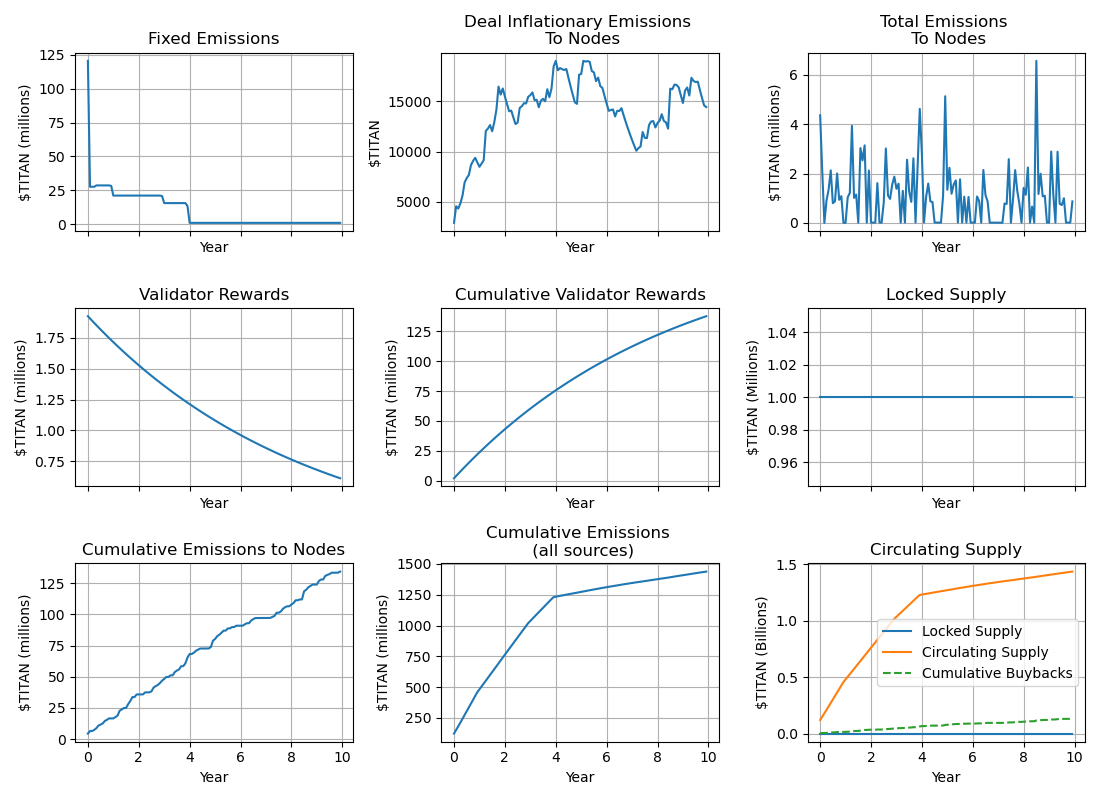

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(11, 8), sharex=True)

# Plot emissions per month
axx = axs[0,0]
axx.plot(results.index/12, results['total_fixed_emissions']/1e6)
axx.set_ylabel('$TITAN (millions)')
axx.set_title('Fixed Emissions')
axx.set_xlabel('Year')
axx.grid(True)

axx = axs[0,1]
axx.plot(results.index/12, results['deal_emissions'])
axx.set_ylabel('$TITAN')
axx.set_xlabel('Year')
axx.set_title('Deal Inflationary Emissions \n To Nodes')
axx.grid(True)

total_to_miners = results['deal_emissions']+results['vested_buybacks']
axx = axs[0,2]
axx.plot(results.index/12, total_to_miners/1e6)
axx.set_ylabel('$TITAN (millions)')
axx.set_xlabel('Year')
axx.set_title('Total Emissions \n To Nodes')
axx.grid(True)

axx = axs[1,0]
axx.plot(results.index/12, results['validator_rewards']/1e6)
axx.set_ylabel('$TITAN (millions)')
axx.set_xlabel('Year')
axx.set_title('Validator Rewards')
axx.grid(True)

axx = axs[1,1]
axx.plot(results.index/12, results['validator_rewards'].cumsum()/1e6)
axx.set_ylabel('$TITAN (millions)')
axx.set_xlabel('Year')
axx.set_title('Cumulative Validator Rewards')
axx.grid(True)

axx = axs[1,2]
axx.plot(results.index/12, results['locked_supply']/1e6)
axx.set_ylabel('$TITAN (Millions)')
axx.set_xlabel('Year')
axx.set_title('Locked Supply')
axx.grid(True)

total_to_miners_cum = total_to_miners.cumsum()
axx = axs[2,0]
axx.plot(results.index/12, total_to_miners_cum/1e6)
axx.set_ylabel('$TITAN (millions)')
axx.set_xlabel('Year')
axx.set_title('Cumulative Emissions to Nodes')
axx.grid(True)

axx = axs[2,1]
axx.plot(results.index/12, results['cumulative_emissions']/1e6)
axx.set_ylabel('$TITAN (millions)')
axx.set_xlabel('Year')
axx.set_title('Cumulative Emissions \n (all sources)')
axx.grid(True)

axx = axs[2,2]
axx.plot(results.index/12, results['locked_supply']/1e9, label='Locked Supply')
axx.plot(results.index/12, results['circulating_supply']/1e9, label='Circulating Supply')
axx.set_ylabel('$TITAN (Billions)')
axx.set_xlabel('Year')
axx.set_title('Circulating Supply')
axx.grid(True)
axx.legend()

if 'vested_buybacks' in results.columns:
    cumulative_buybacks = results['vested_buybacks'].cumsum()
    axx.plot(results.index/12, cumulative_buybacks/1e9, label='Cumulative Buybacks', linestyle='--')
axx.legend()
    
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Supply Breakdown')

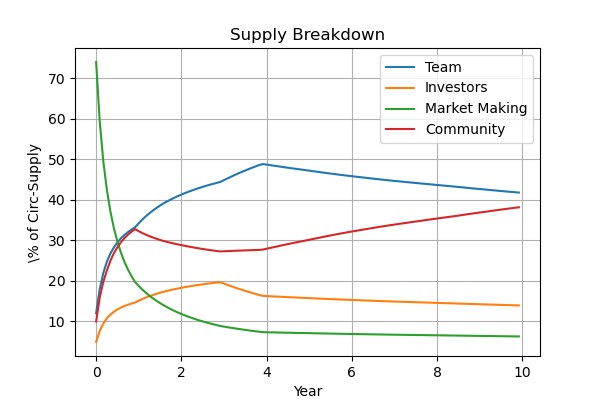

In [9]:
"""
Index([
       'deal_emissions', 'total_emissions', 'buyback_reduction',
       'vested_buybacks', 'validator_rewards', 'total_fixed_emissions',
       'cumulative_emissions', 'net_buyback_impact', 'circulating_supply',
       'locked_supply', 'unlocked_supply'],
      dtype='object')
"""
# plot the proportion of the total cs that is in each category
team = results['fixed_Labs'] + results['fixed_Foundation']
investors = results['fixed_Fundraising - A'] + results['fixed_Fundraising - Seed']
market_making = results['fixed_Market Making Reserve']
community = (
    results['fixed_Ecosystem'] + 
    results['fixed_Testnet Token Allocation'] + 
    results['fixed_Builder, Startup & Devs'] + 
    results['fixed_RPGF'] + results['total_dynamic_emissions']
)

team_cum = team.cumsum()
investors_cum = investors.cumsum()
market_making_cum = market_making.cumsum()
community_cum = community.cumsum()

# plot as a percentage of circ-supply
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.plot(results.index/12, team_cum/results['circulating_supply']*100, label='Team')
ax.plot(results.index/12, investors_cum/results['circulating_supply']*100, label='Investors')
ax.plot(results.index/12, market_making_cum/results['circulating_supply']*100, label='Market Making')
ax.plot(results.index/12, community_cum/results['circulating_supply']*100, label='Community')
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('\% of Circ-Supply')
ax.grid(True)
ax.set_title('Supply Breakdown')

In [10]:
def plot_deals(deals: List[Deal], figsize: Tuple[int, int] = (12, 6)) -> None:
        """
        Visualize deals over time, showing both deal value and token price.
        
        Args:
            deals: List of Deal objects to visualize
            figsize: Figure size as (width, height)
        """
        # Create figure with two subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize, sharex=True)
        
        # Sort deals by start month
        sorted_deals = sorted(deals, key=lambda x: x.start_month)
        
        # Extract data for plotting
        months = [deal.start_month for deal in sorted_deals]
        values = [deal.value for deal in sorted_deals]
        prices = [deal.token_price for deal in sorted_deals]
        geographies = [deal.geography for deal in sorted_deals]
        
        # Create color map for geographies
        unique_geos = list(set(geographies))
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_geos)))
        geo_to_color = {geo: color for geo, color in zip(unique_geos, colors)}
        
        # Plot deal values
        for i, (month, value, geo) in enumerate(zip(months, values, geographies)):
            ax1.scatter(month, value, color=geo_to_color[geo])
            # ax1.text(month, value, f'${value/1e6:.1f}M', ha='right', va='bottom')
        
        # Plot token prices
        for i, (month, price, geo) in enumerate(zip(months, prices, geographies)):
            ax2.scatter(month, price, color=geo_to_color[geo])
            # ax2.text(month, price, f'${price:.2f}', ha='right', va='bottom')
        
        # manually insert legend for mpaping the color of the dot to the geography
        # legend_elements = [plt.scatter([], [], color=colors, marker='o', label=unique_geos[i]) for i in range(len(unique_geos))]
        # ax1.legend(handles=legend_elements, title="Geography")

        # Customize the plots
        ax1.set_ylabel('Deal Value ($)')
        ax1.set_title('Deal Values Over Time')
        ax1.grid(True)
        ax1.legend(title='Geography')
        
        ax2.set_xlabel('Month')
        ax2.set_ylabel('Token Price ($)')
        ax2.set_title('Token Prices at Deal Time')
        ax2.grid(True)
        
        # Adjust layout
        plt.tight_layout()
        plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


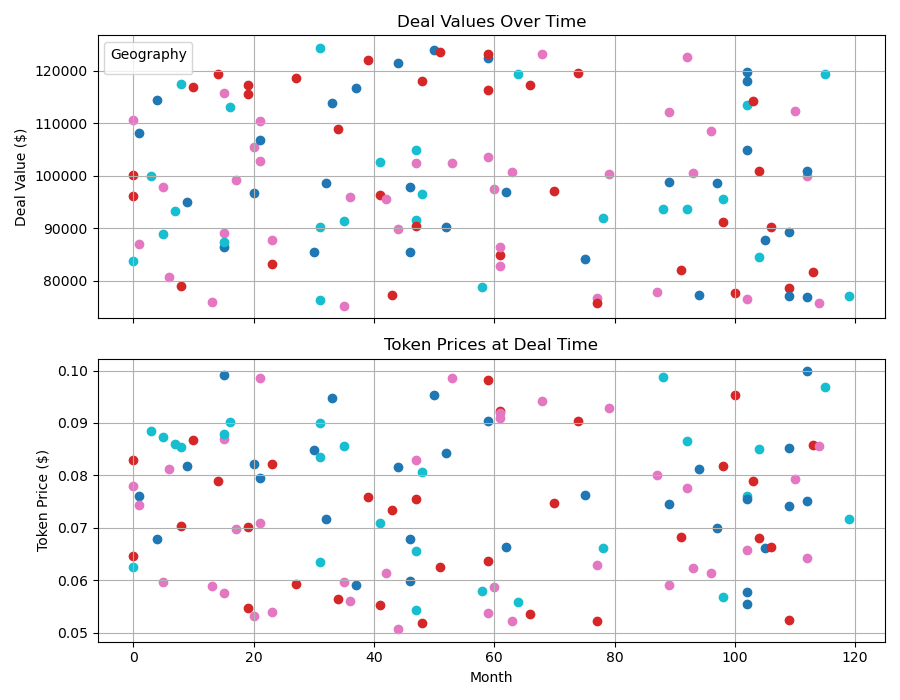

In [11]:
plot_deals(deals, figsize=(9, 7))